In [64]:
import networkx as nx
import pickle

In [65]:
with open('/nfs/students/ayle/gbhcg/data/hsbm6', 'rb') as f:
    hsbm = pickle.load(f)

In [66]:
A = hsbm['A']
layout = hsbm['layout']
T = hsbm['T']
n_leaves = hsbm['n_leaves']

In [67]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram 

COLOR_PALETTE = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762","#004D43", "#8FB0FF", "#997D87", "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80", "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",  "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09", "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66", "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C", "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81", "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00", "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700", "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329", "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

# from random import randint
# COLOR_PALETTE = []

# for i in range(300):
#     COLOR_PALETTE.append('#%06X' % randint(0, 0xFFFFFF))


def get_parents(tree):
    parents = {}
    for parent, children in tree.items():
        for child in children:
            parents[child] = parent
    return parents


def get_path_to_root(child, parents):
    if child not in parents: return []
    parent = parents[child]
    return [parent] + get_path_to_root(parent, parents)


def get_paths_to_root(parents, n_leaves):
    paths_to_root = {}
    for child in parents.keys():
        if child >= n_leaves: continue # internal node
        paths_to_root[child] = get_path_to_root(child, parents)
    return paths_to_root


def get_closest_common_ancestor(path1, path2):
    path1_set = set(path1)
    for node in path2:
        if node in path1_set: return node
    assert(False) # should not be reached


def get_lca_map(paths_to_root, n_leaves):
    lca_map = {}
    for u in range(n_leaves):
        for v in range(u + 1, n_leaves):
            lca = get_closest_common_ancestor(paths_to_root[u], paths_to_root[v])
            lca_map[(u,v)] = lca
            lca_map[(v,u)] = lca
    return lca_map


def get_lvs_map(paths_to_root):
    lvs_map = {}
    for leaf, path in paths_to_root.items():
        for internal in path:
            lvs = lvs_map.get(internal, set())
            lvs.add(leaf)
            lvs_map[internal] = lvs
            
    return lvs_map


def get_helper_maps(tree, n_leaves):
    parents = get_parents(tree)
    paths_to_root = get_paths_to_root(parents, n_leaves)
    lca_map = get_lca_map(paths_to_root, n_leaves)
    lvs_map = get_lvs_map(paths_to_root)
    return lca_map, lvs_map


# Get size of clusters in the hierarchy.
def get_cluster_sizes(T, n_leaves):
    def get_cluster_size(T, node):
        size = 0
        for child in T[node]:
            if child < n_leaves:
                size += 1
            else:
                size += get_cluster_size(T, child)
        return size

    sizes = {}
    for parent in T.keys():
        sizes[parent] = get_cluster_size(T, parent)
    return sizes


# Converts our commonly used tree structure into a linkage matrix.
# Pass in a height map to assign each internal node a height in the dendrogram.
def tree_to_dendrogram(tree, n_leaves, height_map = None):
    tree = [(k, list(v)) for k, v in tree.items()]

    dendrogram = []    
    dendro_map = {i: i for i in range(n_leaves)}
    link_map = {} # Needed for plotting.
    
    mod = True
    
    while len(tree) > 0 and mod:
        mod = False
        for idx, (k, v) in enumerate(tree):
            if height_map != None:
                height = height_map[k - n_leaves] + 1
            else:
                height = k - n_leaves + 1

            # Check if we can add node to dendrogram.
            if not all (n in dendro_map for n in v):
                continue
 
            mod = True
            # This creates the parent node.
            link_map[len(dendrogram)] = k - n_leaves

            dendrogram.append((dendro_map[v[0]], dendro_map[v[1]], height, height))
            
            for n in v[2::]:
                n1 = n_leaves - 1 + len(dendrogram)
                n2 = dendro_map[n]
                link_map[len(dendrogram)] = k - n_leaves
                dendrogram.append((n1, n2, height, height))
            
            dendro_map[k] = n_leaves - 1 + len(dendrogram)
            tree.pop(idx)
            break
            
    if len(tree) > 0:
        raise Exception('Invalid tree!')

    return np.array(dendrogram, float), link_map


def plot_graph_and_hierarchy(graph_type, P, layout, T, n_leaves, node_size, figsize=(15,15)):
    node_map = {} 
    current = 0
    parents = {}

    for parent, children in T.items():
        node_map[parent] = current
        current += 1
        for child in children:
            parents[child] = parent
            
    sizes = get_cluster_sizes(T, n_leaves)
    height_map = {k-n_leaves: v for k,v in sizes.items()}

    den, link_map = tree_to_dendrogram(T, n_leaves, height_map)

    adj_figsize = (figsize[0] * 2 + 1, figsize[1])
    fig = plt.figure(figsize=adj_figsize)

    plt.subplot(1, 2, 1)
    plt.xticks(())
    plt.yticks(())
    extra = {}

    dendrogram(den, leaf_rotation=90., no_labels=True, link_color_func=lambda k: COLOR_PALETTE[node_map[link_map[k-n_leaves] + n_leaves]], **extra);
    
    if graph_type:
        graph = nx.from_numpy_matrix(P > 0)

        colors = [COLOR_PALETTE[node_map[parents[node]]] for node in graph.nodes()]
            
        plt.subplot(1, 2, 2)
        plt.xticks(())
        plt.yticks(())
        nx.draw_networkx_nodes(graph, layout, node_color=colors, node_size=node_size)
        nx.draw_networkx_edges(graph, layout, width=1.0, alpha=0.2)
        plt.savefig('/nfs/homedirs/ayle/guided-research/SNIP-it/hsbm6_graph_den.png')
    
    fig.tight_layout()

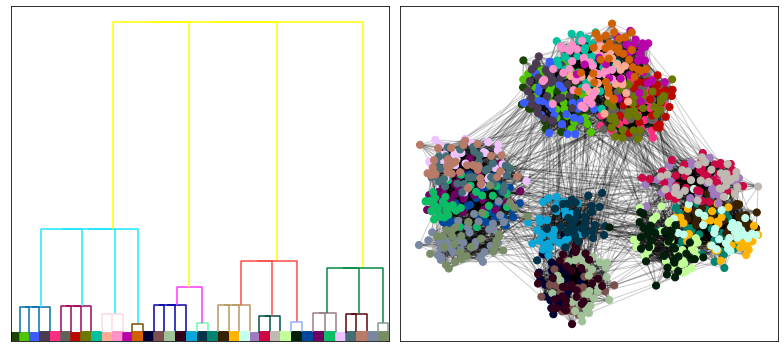

In [68]:
graph = nx.from_numpy_matrix(A > 0)
layout = nx.spring_layout(graph)  
plot_graph_and_hierarchy(True, A, layout, T, n_leaves, node_size = 50, figsize=(5,5))

In [69]:
len(T)

53